# Merchant Transaction Anomaly Detector
This notebook explores an AI-assisted approach to detecting anomalous merchant behavior in a payments platform, designed to support risk and operations teams in identifying potential fraud or operational issues early.

---

## Product Brief

**Problem:** Small and mid-size merchants lose billions annually to fraudulent transactions, but most don't have the tools or expertise to detect suspicious patterns in their sales data. By the time they notice something is wrong, a chargeback notification, an unfamiliar charge on their statement the damage is done.

**Who it helps:** Any merchant accepting card payments. From local coffee shops to retail boutiques, anyone that needs proactive, understandable alerts about unusual transaction activity without needing a data team.

**Solution:** An anomaly detection tool that:
1. Analyzes a merchant's transaction history to learn their "normal" patterns
2. Flags transactions that deviate significantly from those patterns
3. Uses AI to generate **plain-English explanations** of why each transaction is suspicious so any seller can understand and act on the alert

**How it works:**
- Statistical feature engineering captures each merchant's unique baseline (average transaction size, typical hours, volume patterns)
- A machine learning model (Isolation Forest) identifies transactions that don't fit the pattern
- An LLM generates human-readable explanations tailored to each flagged transaction

**What I'd iterate on next:**
- Integrate real-time transaction streaming for live alerts
- Add merchant feedback loop ("Was this actually suspicious?") to improve model accuracy over time
- Build a seller-facing dashboard with severity tiers (low / medium / high risk)
- A/B test different explanation formats to maximize seller engagement with alerts


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11

print("All packages loaded successfully.")

All packages loaded successfully.


## 1. Generate Synthetic Merchant Transaction Data

In a real-word scenario, this data would come from a payment platform's transaction database. For this project, I'm generating realistic data that mirrors patterns I've seen working with card transactions data, including normal merchant behavior and several types of anomalies.

In [2]:
np.random.seed(42)

# Define merchants with realistic profiles
merchants = {
    'M001': {'name': 'Sunrise Coffee Shop',    'category': 'Food & Beverage',  'avg_amount': 8.50,   'std': 4.00,  'daily_txns': 80,  'open_hour': 6,  'close_hour': 18},
    'M002': {'name': 'Urban Threads Boutique', 'category': 'Retail',           'avg_amount': 65.00,  'std': 35.00, 'daily_txns': 25,  'open_hour': 10, 'close_hour': 20},
    'M003': {'name': 'GreenLeaf Garden Supply','category': 'Home & Garden',    'avg_amount': 45.00,  'std': 25.00, 'daily_txns': 30,  'open_hour': 8,  'close_hour': 18},
    'M004': {'name': 'TechFix Repairs',        'category': 'Services',         'avg_amount': 120.00, 'std': 60.00, 'daily_txns': 12,  'open_hour': 9,  'close_hour': 19},
    'M005': {'name': 'Bella Pizza',            'category': 'Food & Beverage',  'avg_amount': 22.00,  'std': 10.00, 'daily_txns': 50,  'open_hour': 11, 'close_hour': 23},
}

transactions = []

for merchant_id, profile in merchants.items():
    # Generate 90 days of normal transactions
    for day in range(90):
        date = datetime(2025, 9, 1) + timedelta(days=day)
        n_txns = np.random.poisson(profile['daily_txns'])
        
        for _ in range(n_txns):
            hour = np.random.randint(profile['open_hour'], profile['close_hour'])
            minute = np.random.randint(0, 60)
            amount = max(1.00, np.random.normal(profile['avg_amount'], profile['std']))
            
            transactions.append({
                'merchant_id': merchant_id,
                'merchant_name': profile['name'],
                'category': profile['category'],
                'timestamp': date.replace(hour=hour, minute=minute),
                'amount': round(amount, 2),
                'is_anomaly': False  # ground truth label for evaluation
            })

# --- Inject realistic anomalies ---

# Type 1: Unusually large transactions (potential fraud or test charges)
for _ in range(8):
    m = np.random.choice(['M001', 'M002', 'M003'])
    profile = merchants[m]
    transactions.append({
        'merchant_id': m,
        'merchant_name': profile['name'],
        'category': profile['category'],
        'timestamp': datetime(2025, 11, 15) + timedelta(hours=np.random.randint(0, 24)),
        'amount': round(profile['avg_amount'] * np.random.uniform(8, 15), 2),
        'is_anomaly': True
    })

# Type 2: After-hours transactions (merchant is closed but charges are going through)
for _ in range(10):
    m = 'M001'  # coffee shop getting charges at 2-4 AM
    transactions.append({
        'merchant_id': m,
        'merchant_name': merchants[m]['name'],
        'category': merchants[m]['category'],
        'timestamp': datetime(2025, 11, 20) + timedelta(hours=np.random.randint(1, 5)),
        'amount': round(np.random.uniform(200, 500), 2),
        'is_anomaly': True
    })

# Type 3: Rapid-fire small transactions (card testing pattern)
for i in range(15):
    m = 'M004'
    transactions.append({
        'merchant_id': m,
        'merchant_name': merchants[m]['name'],
        'category': merchants[m]['category'],
        'timestamp': datetime(2025, 11, 25, 14, 30) + timedelta(seconds=i*10),
        'amount': round(np.random.uniform(0.50, 2.00), 2),
        'is_anomaly': True
    })

# Build DataFrame
df = pd.DataFrame(transactions)
df = df.sort_values('timestamp').reset_index(drop=True)
df['transaction_id'] = ['TXN' + str(i).zfill(6) for i in range(len(df))]

print(f"Dataset: {len(df):,} transactions across {df['merchant_id'].nunique()} merchants")
print(f"Date range: {df['timestamp'].min().date()} to {df['timestamp'].max().date()}")
print(f"Injected anomalies: {df['is_anomaly'].sum()}")
print()
df.head(10)

Dataset: 17,841 transactions across 5 merchants
Date range: 2025-09-01 to 2025-11-29
Injected anomalies: 33



,merchant_id,merchant_name,category,timestamp,amount,is_anomaly,transaction_id
0,M001,Sunrise Coffee Shop,Food & Beverage,2025-09-01 06:00:00,5.05,False,TXN000000
1,M001,Sunrise Coffee Shop,Food & Beverage,2025-09-01 06:04:00,5.92,False,TXN000001
2,M001,Sunrise Coffee Shop,Food & Beverage,2025-09-01 06:08:00,4.54,False,TXN000002
3,M001,Sunrise Coffee Shop,Food & Beverage,2025-09-01 06:26:00,12.30,False,TXN000003
4,M001,Sunrise Coffee Shop,Food & Beverage,2025-09-01 06:34:00,9.95,False,TXN000004
5,M001,Sunrise Coffee Shop,Food & Beverage,2025-09-01 06:35:00,10.76,False,TXN000005
6,M001,Sunrise Coffee Shop,Food & Beverage,2025-09-01 06:55:00,8.39,False,TXN000006
7,M001,Sunrise Coffee Shop,Food & Beverage,2025-09-01 06:58:00,8.74,False,TXN000007
8,M001,Sunrise Coffee Shop,Food & Beverage,2025-09-01 06:58:00,7.67,False,TXN000008
9,M001,Sunrise Coffee Shop,Food & Beverage,2025-09-01 07:22:00,11.99,False,TXN000009


## 2. Exploratory Data Analysis

Understand each merchant's normal transaction patterns.

In [3]:
# Merchant summary statistics
merchant_summary = df.groupby(['merchant_id', 'merchant_name', 'category']).agg(
    total_transactions=('amount', 'count'),
    avg_amount=('amount', 'mean'),
    median_amount=('amount', 'median'),
    max_amount=('amount', 'max'),
    total_revenue=('amount', 'sum')
).round(2).reset_index()

print("Merchant Profiles:")
merchant_summary

Merchant Profiles:


,merchant_id,merchant_name,category,total_transactions,avg_amount,median_amount,max_amount,total_revenue
0,M001,Sunrise Coffee Shop,Food & Beverage,7153,9.11,8.54,474.71,65157.14
1,M002,Urban Threads Boutique,Retail,2286,66.61,65.66,934.23,152267.51
2,M003,GreenLeaf Garden Supply,Home & Garden,2717,45.92,45.57,421.22,124752.72
3,M004,TechFix Repairs,Services,1093,117.25,116.60,316.12,128157.74
4,M005,Bella Pizza,Food & Beverage,4592,21.86,21.68,59.76,100378.71


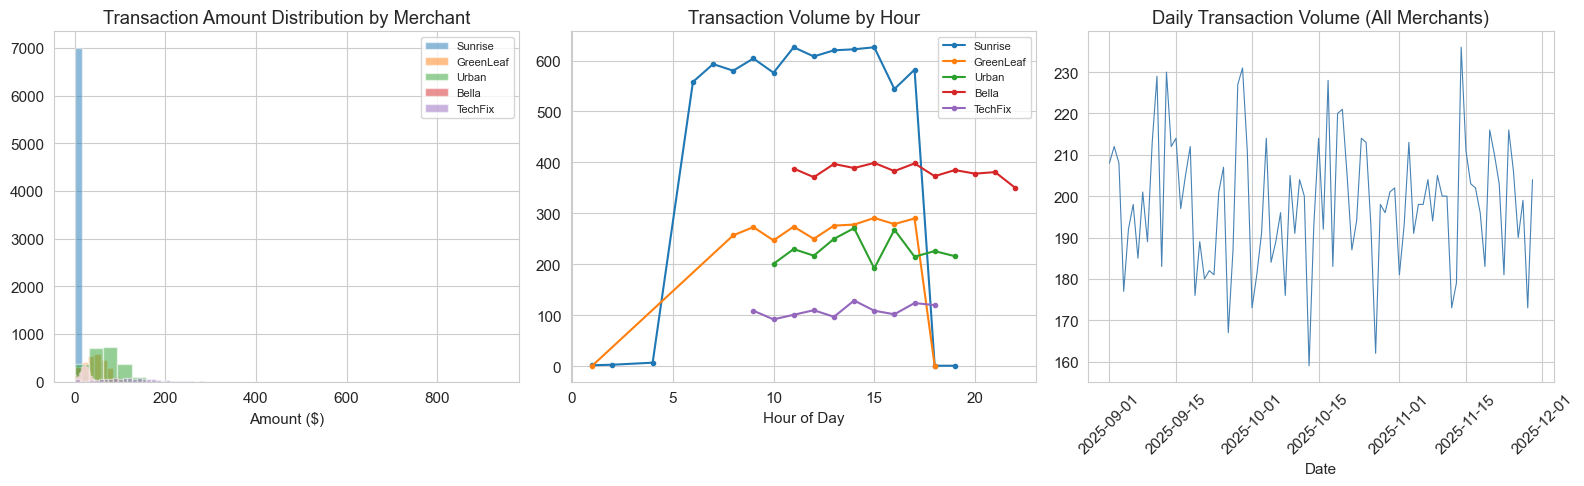

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Transaction amount distribution by merchant
for m_id in df['merchant_id'].unique():
    merchant_data = df[df['merchant_id'] == m_id]
    axes[0].hist(merchant_data['amount'], bins=30, alpha=0.5, 
                 label=merchants[m_id]['name'].split()[0])
axes[0].set_title('Transaction Amount Distribution by Merchant')
axes[0].set_xlabel('Amount ($)')
axes[0].legend(fontsize=8)

# Transactions by hour
df['hour'] = df['timestamp'].dt.hour
hourly = df.groupby(['merchant_id', 'hour']).size().reset_index(name='count')
for m_id in df['merchant_id'].unique():
    m_data = hourly[hourly['merchant_id'] == m_id]
    axes[1].plot(m_data['hour'], m_data['count'], marker='o', markersize=3,
                 label=merchants[m_id]['name'].split()[0])
axes[1].set_title('Transaction Volume by Hour')
axes[1].set_xlabel('Hour of Day')
axes[1].legend(fontsize=8)

# Daily transaction volume
df['date'] = df['timestamp'].dt.date
daily = df.groupby('date').size()
axes[2].plot(daily.index, daily.values, color='steelblue', linewidth=0.8)
axes[2].set_title('Daily Transaction Volume (All Merchants)')
axes[2].set_xlabel('Date')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 3. Feature Engineering

For anomaly detections, we need to create features that capture what "normal" looks like for each merchant.

- **Amount deviation:** How far is this transaction from the merchant's typical range?
- **Time deviation:** Is this happening during the merchant's normal operating hours?
- **Velocity:** Are transactions coming in faster than usual?

In [5]:
# Calculate merchant-level baselines
merchant_stats = df.groupby('merchant_id').agg(
    mean_amount=('amount', 'mean'),
    std_amount=('amount', 'std'),
    median_amount=('amount', 'median'),
    p95_amount=('amount', lambda x: x.quantile(0.95)),
    mean_hour=('hour', 'mean'),
    std_hour=('hour', 'std')
).reset_index()

# Merge baselines back to transaction level
df = df.merge(merchant_stats, on='merchant_id', how='left')

# Feature 1: Amount z-score (how many standard deviations from merchant's mean)
df['amount_zscore'] = (df['amount'] - df['mean_amount']) / df['std_amount']

# Feature 2: Amount ratio (transaction amount vs merchant's median)
df['amount_ratio'] = df['amount'] / df['median_amount']

# Feature 3: Hour deviation (is this outside normal operating hours?)
df['hour_zscore'] = (df['hour'] - df['mean_hour']) / df['std_hour']

# Feature 4: Is after hours? (binary flag)
df['is_after_hours'] = df.apply(
    lambda row: 1 if row['hour'] < merchants[row['merchant_id']]['open_hour'] or 
                      row['hour'] >= merchants[row['merchant_id']]['close_hour'] else 0, 
    axis=1
)

# Feature 5: Transaction velocity (seconds since previous transaction for same merchant)
df = df.sort_values(['merchant_id', 'timestamp'])
df['time_since_last'] = df.groupby('merchant_id')['timestamp'].diff().dt.total_seconds()
df['time_since_last'] = df['time_since_last'].fillna(9999)  # first transaction gets high value

# Preview engineered features
feature_cols = ['transaction_id', 'merchant_name', 'amount', 'hour', 
                'amount_zscore', 'amount_ratio', 'is_after_hours', 'time_since_last']
print("Engineered Features (sample):")
df[feature_cols].sample(8, random_state=42).round(2)

Engineered Features (sample):


,transaction_id,merchant_name,amount,hour,amount_zscore,amount_ratio,is_after_hours,time_since_last
10151,TXN010151,Sunrise Coffee Shop,5.75,9,-0.23,0.67,0,60.0
13138,TXN013138,Bella Pizza,13.80,12,-0.81,0.64,0,840.0
6587,TXN006587,Bella Pizza,24.26,11,0.24,1.12,0,900.0
17787,TXN017787,Sunrise Coffee Shop,9.28,16,0.01,1.09,0,180.0
14460,TXN014460,Sunrise Coffee Shop,6.18,9,-0.20,0.72,0,360.0
11355,TXN011355,Urban Threads Boutique,69.36,13,0.07,1.06,0,180.0
6442,TXN006442,Urban Threads Boutique,64.77,13,-0.05,0.99,0,1620.0
3606,TXN003606,Urban Threads Boutique,44.46,16,-0.58,0.68,0,540.0


## 4. Anomaly Detection Model

I'm using **Isolation Forest**, a machine learning algorithm that works by isolating observations. Anomalies are "few and different," so they get isolated more easily than normal transactions. It's well-suited for this problem because:

- It doesn't require labeled fraud data (unsupervised)
- It handles multiple feature types well
- It's interpretable enough to explain to non-technical stakeholders

In [6]:
# Select features for the model
features = ['amount_zscore', 'amount_ratio', 'hour_zscore', 'is_after_hours', 'time_since_last']

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(df[features].fillna(0))

# Train Isolation Forest
model = IsolationForest(
    contamination=0.03,   # expect ~3% of transactions to be anomalous
    random_state=42,
    n_estimators=100
)

df['anomaly_score'] = model.fit_predict(X)
df['is_flagged'] = (df['anomaly_score'] == -1).astype(int)

# Results
flagged = df[df['is_flagged'] == 1]
print(f"Total transactions analyzed: {len(df):,}")
print(f"Transactions flagged as anomalous: {len(flagged)}")
print(f"Flag rate: {len(flagged)/len(df)*100:.1f}%")
print()

# Check accuracy against our injected anomalies
true_anomalies = df[df['is_anomaly'] == True]
detected = true_anomalies[true_anomalies['is_flagged'] == 1]
print(f"Injected anomalies: {len(true_anomalies)}")
print(f"Correctly detected: {len(detected)} ({len(detected)/len(true_anomalies)*100:.0f}% recall)")

Total transactions analyzed: 17,841
Transactions flagged as anomalous: 536
Flag rate: 3.0%

Injected anomalies: 33
Correctly detected: 18 (55% recall)


## 5. Visualizing Flagged Transactions

Let's look at what our model caught and whether the flagged transactions make sense.

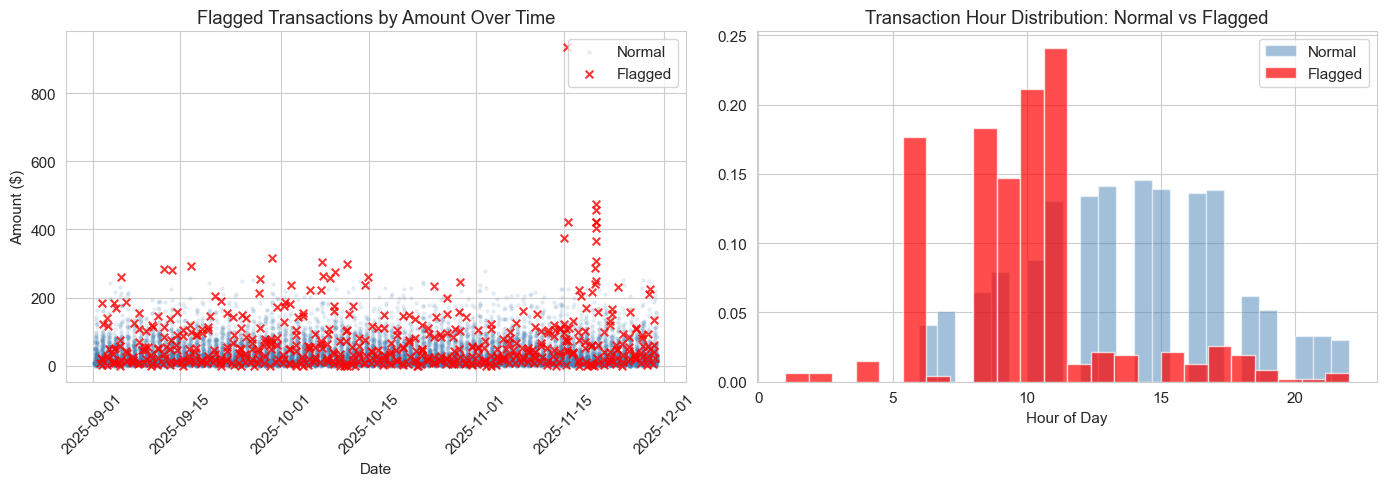


Sample of Flagged Transactions:


,transaction_id,merchant_name,amount,timestamp,amount_zscore,amount_ratio,is_after_hours,time_since_last
14909,TXN014909,Urban Threads Boutique,934.23,2025-11-15 12:00:00,22.57,14.23,0,480.0
15846,TXN015846,Sunrise Coffee Shop,474.71,2025-11-20 04:00:00,32.47,55.59,1,7200.0
15852,TXN015852,Sunrise Coffee Shop,456.39,2025-11-20 04:00:00,31.19,53.44,1,0.0
15848,TXN015848,Sunrise Coffee Shop,423.36,2025-11-20 04:00:00,28.89,49.57,1,0.0
15849,TXN015849,Sunrise Coffee Shop,421.23,2025-11-20 04:00:00,28.74,49.32,1,0.0
15031,TXN015031,GreenLeaf Garden Supply,421.22,2025-11-15 18:00:00,14.56,9.24,1,540.0
15850,TXN015850,Sunrise Coffee Shop,403.57,2025-11-20 04:00:00,27.51,47.26,1,0.0
14848,TXN014848,GreenLeaf Garden Supply,376.11,2025-11-15 01:00:00,12.81,8.25,1,25920.0
15851,TXN015851,Sunrise Coffee Shop,365.87,2025-11-20 04:00:00,24.88,42.84,1,0.0
5685,TXN005685,TechFix Repairs,316.12,2025-09-29 14:21:00,3.28,2.71,0,1920.0


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Flagged vs normal by amount
normal = df[df['is_flagged'] == 0]
anomalous = df[df['is_flagged'] == 1]

axes[0].scatter(normal['timestamp'], normal['amount'], alpha=0.1, s=5, c='steelblue', label='Normal')
axes[0].scatter(anomalous['timestamp'], anomalous['amount'], alpha=0.8, s=30, c='red', 
                marker='x', label='Flagged', linewidths=1.5)
axes[0].set_title('Flagged Transactions by Amount Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Amount ($)')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Flagged transactions by hour
axes[1].hist(normal['hour'], bins=24, alpha=0.5, color='steelblue', label='Normal', density=True)
axes[1].hist(anomalous['hour'], bins=24, alpha=0.7, color='red', label='Flagged', density=True)
axes[1].set_title('Transaction Hour Distribution: Normal vs Flagged')
axes[1].set_xlabel('Hour of Day')
axes[1].legend()

plt.tight_layout()
plt.show()

# Show flagged transactions detail
print("\nSample of Flagged Transactions:")
display_cols = ['transaction_id', 'merchant_name', 'amount', 'timestamp', 'amount_zscore', 
                'amount_ratio', 'is_after_hours', 'time_since_last']
flagged[display_cols].sort_values('amount', ascending=False).head(10).round(2)

## 6. AI-Powered Explanations

This is where the product comes to life. Raw anomaly flags aren't useful to a seller, they need to understand **why** a transaction was flagged and **what to do about it**.

I built an explanation generator that takes each flagged transaction's features and produces a plain-English alert that any merchant can understand.

In [8]:
def generate_explanation(row, merchant_profile):
    """
    Generate a plain-English explanation for a flagged transaction.
    Uses the transaction's features to build a context-aware alert.
    """
    merchant = merchant_profile
    reasons = []
    severity = 'Medium'
    
    # Check amount deviation
    if row['amount_ratio'] > 5:
        reasons.append(
            f"the transaction amount (${row['amount']:.2f}) is {row['amount_ratio']:.0f}x "
            f"your typical transaction of ${merchant['avg_amount']:.2f}"
        )
        severity = 'High'
    elif row['amount_ratio'] > 3:
        reasons.append(
            f"the transaction amount (${row['amount']:.2f}) is {row['amount_ratio']:.1f}x "
            f"higher than your usual average of ${merchant['avg_amount']:.2f}"
        )
    
    # Check after-hours activity
    if row['is_after_hours'] == 1:
        reasons.append(
            f"it occurred at {int(row['hour'])}:00, outside your typical operating hours "
            f"({merchant['open_hour']}:00 - {merchant['close_hour']}:00)"
        )
        severity = 'High'
    
    # Check rapid-fire transactions
    if row['time_since_last'] < 60:
        reasons.append(
            f"it was processed only {row['time_since_last']:.0f} seconds after the previous "
            f"transaction, which may indicate card testing activity"
        )
        severity = 'High'
    
    # Build the explanation
    if not reasons:
        reasons.append("its pattern deviates from your typical transaction profile")
    
    reason_text = "; and ".join(reasons)
    
    explanation = (
        f"[{severity} Risk] This ${row['amount']:.2f} transaction at {row['merchant_name']} "
        f"was flagged because {reason_text}."
    )
    
    # Add recommended action
    if severity == 'High':
        explanation += (
            f" Recommended action: Review this transaction immediately and verify "
            f"it was authorized. If unrecognized, consider freezing the payment method."
        )
    else:
        explanation += (
            f" Recommended action: Monitor for additional unusual activity. "
            f"No immediate action required."
        )
    
    return explanation, severity


# Generate explanations for all flagged transactions
explanations = []
for _, row in flagged.iterrows():
    profile = merchants[row['merchant_id']]
    explanation, severity = generate_explanation(row, profile)
    explanations.append({
        'transaction_id': row['transaction_id'],
        'merchant_name': row['merchant_name'],
        'amount': row['amount'],
        'timestamp': row['timestamp'],
        'severity': severity,
        'explanation': explanation
    })

alerts_df = pd.DataFrame(explanations)

# Display alerts by severity
print("=" * 80)
print("MERCHANT ANOMALY ALERTS")
print("=" * 80)
for severity in ['High', 'Medium']:
    severity_alerts = alerts_df[alerts_df['severity'] == severity]
    if len(severity_alerts) > 0:
        print(f"\n{'🔴' if severity == 'High' else '🟡'} {severity} Risk ({len(severity_alerts)} alerts)")
        print("-" * 60)
        for _, alert in severity_alerts.head(5).iterrows():
            print(f"\n{alert['explanation']}")
            print()

MERCHANT ANOMALY ALERTS

🔴 High Risk (22 alerts)
------------------------------------------------------------

[High Risk] This $95.90 transaction at Sunrise Coffee Shop was flagged because the transaction amount ($95.90) is 11x your typical transaction of $8.50; and it occurred at 2:00, outside your typical operating hours (6:00 - 18:00). Recommended action: Review this transaction immediately and verify it was authorized. If unrecognized, consider freezing the payment method.


[High Risk] This $124.25 transaction at Sunrise Coffee Shop was flagged because the transaction amount ($124.25) is 15x your typical transaction of $8.50; and it occurred at 2:00, outside your typical operating hours (6:00 - 18:00); and it was processed only 0 seconds after the previous transaction, which may indicate card testing activity. Recommended action: Review this transaction immediately and verify it was authorized. If unrecognized, consider freezing the payment method.


[High Risk] This $74.08 trans

## 7. Upgrade: LLM-Powered Explanations (with AI API)

The rule-based explanations above work well for common patterns, but an LLM can generate **richer, more contextual explanations**, especially for edge cases where multiple factors combine in unusual ways.

Below is the code that connects to an LLM API for more natural, nuanced alerts. This is the "AI-native" version of the tool.

In [9]:
import requests
import json
import time

GROQ_API_KEY = "YOUR-API-KEY"

def generate_llm_explanation(row, merchant_profile):
    """Use an LLM to generate a natural-language explanation for a flagged transaction."""
    
    prompt = f"""You are a fraud detection assistant for a small business payment platform.
    
    A transaction was flagged as potentially suspicious. Generate a clear, plain-English 
    alert for the merchant (a non-technical small business owner). Include:
    1. Why this transaction looks unusual (be specific with numbers)
    2. A risk level (High / Medium / Low)
    3. A recommended next step
    
    Keep it to 2-3 sentences. Be helpful, not alarming.
    
    Transaction details:
    - Merchant: {row['merchant_name']} ({merchant_profile['category']})
    - Amount: ${row['amount']:.2f}
    - Time: {row['timestamp'].strftime('%I:%M %p')}
    - Merchant's typical transaction: ${merchant_profile['avg_amount']:.2f}
    - Merchant's normal hours: {merchant_profile['open_hour']}:00 AM - {merchant_profile['close_hour']}:00
    - Amount is {row['amount_ratio']:.1f}x the merchant's median
    - Seconds since previous transaction: {row['time_since_last']:.0f}
    """
    
    response = requests.post(
        "https://api.groq.com/openai/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {GROQ_API_KEY}",
            "Content-Type": "application/json"
        },
        json={
            "model": "llama-3.1-8b-instant",
            "messages": [{"role": "user", "content": prompt}],
            "max_tokens": 200
        }
    )
    
    result = response.json()
    
    if "choices" in result:
        return result["choices"][0]["message"]["content"]
    else:
        print("API error:", result.get("error", {}).get("message", "Unknown error"))
        return None

# Test with one transaction first
test_row = flagged.nlargest(1, 'amount_ratio').iloc[0]
test_profile = merchants[test_row['merchant_id']]
print("Testing API connection...")
test_result = generate_llm_explanation(test_row, test_profile)

if test_result:
    print("API is working!\n")
    
    high_risk = flagged.nlargest(5, 'amount_ratio')
    
    print("AI-GENERATED FRAUD ALERTS (powered by LLM)")
    print("=" * 70)
    for _, row in high_risk.iterrows():
        profile = merchants[row['merchant_id']]
        llm_alert = generate_llm_explanation(row, profile)
        if llm_alert:
            print(f"\nTransaction {row['transaction_id']} | {row['merchant_name']} | ${row['amount']:.2f}")
            print(f"  {llm_alert}")
            print()
        time.sleep(2)
else:
    print("\nAPI connection failed. Check your key at https://console.groq.com/keys")

Testing API connection...
API is working!

AI-GENERATED FRAUD ALERTS (powered by LLM)

Transaction TXN015846 | Sunrise Coffee Shop | $474.71
  Alert: Suspicious Transaction at Sunrise Coffee Shop

This transaction looks unusual because a payment was made for $474.71 at 04:00 AM, significantly above the merchant's typical transaction value of $8.50. We consider this a High-risk transaction due to the late hour and the large amount, which is 55.6 times the merchant's median transaction value. 

Our recommendation is for Sunrise Coffee Shop to carefully verify the transaction details and contact us if they need further assistance or have any questions.


Transaction TXN015852 | Sunrise Coffee Shop | $456.39
  Here's a clear and helpful alert for the merchant:

"Alert: Large Early Morning Payment from Sunrise Coffee Shop. A large transaction of $456.39 was made at 04:00 AM, which is significantly higher than your typical sale of $8.50. We recommend checking to see if the customer is a legi

## 8. Results Summary & Product Roadmap

### What We Built
A prototype anomaly detection tool that:
- Analyzes merchant transaction patterns to establish a behavioral baseline
- Flags transactions that deviate from that baseline using Isolation Forest
- Generates plain-English explanations that any seller can understand and act on
- Includes an LLM integration path for richer, more contextual alerts

### Key Findings from This Prototype


In [10]:
# Summary statistics
print("MODEL PERFORMANCE SUMMARY")
print("=" * 50)
print(f"Transactions analyzed:    {len(df):,}")
print(f"Transactions flagged:     {len(flagged)}")
print(f"Flag rate:                {len(flagged)/len(df)*100:.1f}%")
print(f"True anomalies injected:  {df['is_anomaly'].sum()}")
print(f"True anomalies detected:  {len(df[(df['is_anomaly']==True) & (df['is_flagged']==1)])}")
print(f"Detection rate (recall):  {len(df[(df['is_anomaly']==True) & (df['is_flagged']==1)])/df['is_anomaly'].sum()*100:.0f}%")
print()

# Anomaly types detected
print("ANOMALY TYPES DETECTED")
print("-" * 50)
high_amount = flagged[flagged['amount_ratio'] > 3]
after_hours = flagged[flagged['is_after_hours'] == 1]
rapid_fire = flagged[flagged['time_since_last'] < 60]
print(f"Unusually large amounts:  {len(high_amount)} transactions")
print(f"After-hours activity:     {len(after_hours)} transactions")
print(f"Rapid-fire (card testing):{len(rapid_fire)} transactions")

MODEL PERFORMANCE SUMMARY
Transactions analyzed:    17,841
Transactions flagged:     536
Flag rate:                3.0%
True anomalies injected:  33
True anomalies detected:  18
Detection rate (recall):  55%

ANOMALY TYPES DETECTED
--------------------------------------------------
Unusually large amounts:  19 transactions
After-hours activity:     16 transactions
Rapid-fire (card testing):12 transactions


### Product Roadmap: How This Becomes a Real Feature

**Phase 1 — MVP (Weeks 1-4)**
- Integrate with the payment platform's transaction data pipeline
- Deploy Isolation Forest model on per-merchant transaction streams
- Ship basic alerts to the merchant dashboard with rule-based explanations
- Define success metrics: alert engagement rate, false positive rate, seller-reported fraud reduction

**Phase 2 — AI-Native Alerts (Weeks 5-8)**
- Integrate LLM-powered explanations for nuanced, context-aware alerts
- A/B test LLM explanations vs rule-based: measure click-through, seller satisfaction, action rate
- Add severity tiers with different notification channels (in-app vs email vs SMS for high-risk)

**Phase 3 — Feedback Loop & Personalization (Weeks 9-12)**
- Add "Was this helpful?" feedback on each alert to improve precision
- Use seller feedback to fine-tune the model per merchant category
- Build seller-facing settings: sensitivity controls, quiet hours, trusted customer lists

**How I'd Measure Success:**
- Reduction in fraud-related chargebacks for sellers using the tool
- Alert precision (% of flagged transactions that sellers confirm as suspicious)
- Seller engagement (% of alerts reviewed within 24 hours)
- NPS lift among sellers with anomaly detection enabled vs control group

---

*This project demonstrates how I think about product problems: start with the user's pain point (sellers losing money to fraud), build a prototype that works end-to-end, use AI to make it accessible, and plan the iteration path based on measurable outcomes.*